In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import joblib
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


In [2]:
df = pd.read_csv('final_data.csv',keep_default_na = False)
df

,role,company_type,Avg_Experience,primary_location,Job_Mode,final_salary
0,Data Scientist Associate,Product-Based,3.0,Bengaluru,Onsite,7.000
1,Data Scientist Associate,Service-Based,5.0,Hyderabad,Onsite,12.760
2,Data Scientist Associate,Service-Based,8.0,Hyderabad,Onsite,21.175
3,Data Scientist Associate,Service-Based,4.0,Hyderabad,Onsite,9.955
4,Data Scientist Associate,Other,3.5,Hyderabad,Onsite,3.500
...,...,...,...,...,...,...
1725,Senior Data Engineer,Other,9.5,Not Applicable,Remote,45.000
1726,Senior Data Engineer,Other,7.5,Bengaluru,Onsite,22.500
1727,Senior Data Engineer,Service-Based,7.5,Not Applicable,Remote,45.000
1728,Senior Data Engineer,Other,10.5,Chennai,Onsite,37.500


In [5]:
df.primary_location.value_counts()

primary_location
Hyderabad         621
Not Applicable    388
Bengaluru         280
Mumbai             86
Kolkata            71
Pune               68
Chennai            52
Noida              47
Gurugram           42
Navi Mumbai        23
Other              19
Kochi              10
Ahmedabad          10
New Delhi           8
Indore              3
Jaipur              2
Name: count, dtype: int64

In [7]:
df.isnull().sum()

role                0
company_type        0
Avg_Experience      0
primary_location    0
Job_Mode            0
final_salary        0
dtype: int64

# FE

In [9]:
def salary_category(final_salary):
    if final_salary < 5.0:
        return "Low"
    elif final_salary < 15.0:
        return "Medium"
    elif final_salary < 50.0:
        return "High"
    else:
        return "Very High"

df['salary_category'] = df['final_salary'].apply(salary_category)

###### Extracting Tier from location

In [10]:
metro_cities = ["Hyderabad", "Bengaluru", "Pune", "Mumbai", "Kolkata", "Chennai", "Noida", "Gurugram", "Delhi"]
df["City_Type"] = df["primary_location"].apply(lambda x: "Metro" if x in metro_cities else "Non-Metro")

In [11]:
def categorize_region(primary_location):
    north = ["Delhi", "Gurugram", "Noida","Chandigarh","Jaipur","Haridwar","Lucknow","Shimla","Udaipur","Ludhiana",
            "Srinagar","Dehradun","Prayagraj","Jhansi","Varanasi"]
    south = ["Bengaluru", "Hyderabad", "Chennai","Coimbatore","Kochi","Thiruvananthapuram","Lakshadweep","Andhra Pradesh",
            "Kozhikode","Puducherry","Tiruchirapalli"]
    west = ["Mumbai", "Pune", "Ahmedabad","Surat","Nagpur","Panaji","Nashik"]
    east = ["Kolkata","Bhubaneswar","Patna","Kalyani"]
    central = ["Indore","Bhopal","Tirodi"]
    NA = {"Not Applicable"}

    if primary_location in north:
        return "North"
    elif primary_location in south:
        return "South"
    elif primary_location in west:
        return "West"
    elif primary_location in east:
        return "East"
    elif primary_location in central:
        return "Central"
    elif primary_location in NA:
        return "Not Applicable"
    
    
    else:
        return "Other"

df["Region"] = df["primary_location"].apply(categorize_region)

###### Extracting Experinece Lvels

In [12]:
# Define experience bins and labels
df['Avg_Experience'] = df['Avg_Experience'].astype(int)
bins = [0, 2, 5, 10, 15, 20,50]  
labels = ["Entry", "Junior", "Mid", "Senior", "Expert","Director"]

# Create a new feature
df["experience_level"] = pd.cut(df["Avg_Experience"], bins=bins, labels=labels)
df["experience_level"] = df["experience_level"].astype(str)

###### Extracting job level from role

In [13]:
# Define job level mapping based on roles
job_levels = {
    "Data Scientist Associate": "Junior",
    "Junior Data Scientist": "Junior",
    "Data Scientist": "Mid",
    "Senior Data Scientist": "Senior",
    "Lead Data Scientist": "Lead",
    "Principal Data Scientist": "Principal",
    "Data Science Manager": "Manager",
    
    "Machine Learning Engineer": "Senior",
    "Artificial Intelligence Engineer": "Senior",
    
    "Data Science Analyst": "Mid",
    "Data Analyst": "Junior",
    "Lead Data Analyst": "Lead",
    "Senior Data Analyst": "Senior",
    
    "Data Engineer": "Mid",
    "Senior Data Engineer": "Senior",
    "Lead Data Engineer": "Lead"
}

# Apply mapping
df["job_level"] = df["role"].map(job_levels).fillna("Unknown")

In [14]:
df.head()

,role,company_type,Avg_Experience,primary_location,Job_Mode,final_salary,salary_category,City_Type,Region,experience_level,job_level
0,Data Scientist Associate,Product-Based,3,Bengaluru,Onsite,7.000,Medium,Metro,South,Junior,Junior
1,Data Scientist Associate,Service-Based,5,Hyderabad,Onsite,12.760,Medium,Metro,South,Junior,Junior
2,Data Scientist Associate,Service-Based,8,Hyderabad,Onsite,21.175,High,Metro,South,Mid,Junior
3,Data Scientist Associate,Service-Based,4,Hyderabad,Onsite,9.955,Medium,Metro,South,Junior,Junior
4,Data Scientist Associate,Other,3,Hyderabad,Onsite,3.500,Low,Metro,South,Junior,Junior


In [15]:
df.describe()

,Avg_Experience,final_salary
count,1730.000000,1730.000000
mean,6.402312,21.680162
std,2.875676,15.053287
min,0.000000,0.500000
25%,4.000000,11.755000
50%,6.000000,18.700000
75%,8.000000,27.876250
max,19.000000,173.650000


In [16]:
df.describe(include ='O')

,role,company_type,primary_location,Job_Mode,salary_category,City_Type,Region,experience_level,job_level
count,1730,1730,1730,1730,1730,1730,1730,1730,1730
unique,16,6,16,3,4,2,7,6,6
top,Data Science Analyst,Service-Based,Hyderabad,Onsite,High,Metro,South,Mid,Senior
freq,155,620,621,1342,1026,1267,963,910,516


# Encoding

In [17]:
role_mapping = {'Data Scientist Associate' : 0, 'Junior Data Scientist' : 1,
       'Data Scientist' : 2, 'Machine Learning Engineer' : 3,
       'Artificial Intelligence Engineer' : 4, 'Senior Data Scientist' : 5,
       'Lead Data Scientist' : 6, 'Principal Data Scientist' : 7,
       'Data Science Manager' : 8, 'Data Science Analyst' : 9, 'Data Analyst' : 10,
       'Lead Data Analyst' : 11, 'Senior Data Analyst' : 12, 'Data Engineer' : 13,
       'Lead Data Engineer' : 14, 'Senior Data Engineer' : 15}
df['role'] = df['role'].map(role_mapping)

In [18]:
company_mapping = {'Product-Based' : 0, 'Service-Based' : 1, 'Other' : 2, 'Mid-Size' : 3, 'MNC' : 4,
       'Startup' : 5}
df['company_type'] = df['company_type'].map(company_mapping)

In [19]:
location_mapping = {'Bengaluru':0, 'Hyderabad':1, 'Not Applicable':2, 'Kolkata':3, 'Mumbai':4, 'Noida':5,
       'Chennai':6, 'Gurugram':7, 'Kochi':8, 'Pune':9, 'Other':10, 'Navi Mumbai':11,
       'Ahmedabad':12, 'New Delhi':13, 'Indore':14, 'Jaipur':15}
df['primary_location'] = df['primary_location'].map(location_mapping)

In [20]:
job_mapping = {'Onsite':0, 'Hybrid':1, 'Remote':2}
df['Job_Mode'] = df['Job_Mode'].map(job_mapping)

In [21]:
salary_category_mapping = {'Medium': 0, 'High' : 1, 'Low' : 2, 'Very High' : 3}
df['salary_category'] = df['salary_category'].map(salary_category_mapping)

In [22]:
city_mapping = {'Metro' : 0, 'Non-Metro' : 1}
df['City_Type'] = df['City_Type'].map(city_mapping)

In [23]:
region_mapping = {'South' : 0, 'Not Applicable' : 1, 'East' : 2, 'West' : 3, 'North' : 4, 'Other' : 5,
       'Central' : 6}
df['Region'] = df['Region'].map(region_mapping)

In [24]:
joblevel_mapping = {'Junior' : 0, 'Mid' : 1, 'Senior' : 2, 'Lead' : 3, 'Principal' : 4, 'Manager' : 5}

df['job_level'] = df['job_level'].map(joblevel_mapping)

In [25]:
explevel_mapping = {'Junior' : 0, 'Mid' : 1, 'Senior' : 2, 'Entry' : 3, 'Expert' : 4, 'nan' : 5}
df['experience_level'] = df['experience_level'].map(explevel_mapping)

In [26]:
df['final_salary'] = df['final_salary'].round(1)

In [27]:
df

,role,company_type,Avg_Experience,primary_location,Job_Mode,final_salary,salary_category,City_Type,Region,experience_level,job_level
0,0,0,3,0,0,7.0,0,0,0,0,0
1,0,1,5,1,0,12.8,0,0,0,0,0
2,0,1,8,1,0,21.2,1,0,0,1,0
3,0,1,4,1,0,10.0,0,0,0,0,0
4,0,2,3,1,0,3.5,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1725,15,2,9,2,2,45.0,1,1,1,1,2
1726,15,2,7,0,0,22.5,1,0,0,1,2
1727,15,1,7,2,2,45.0,1,1,1,1,2
1728,15,2,10,6,0,37.5,1,0,0,1,2


In [28]:
df.isnull().sum()

role                0
company_type        0
Avg_Experience      0
primary_location    0
Job_Mode            0
final_salary        0
salary_category     0
City_Type           0
Region              0
experience_level    0
job_level           0
dtype: int64

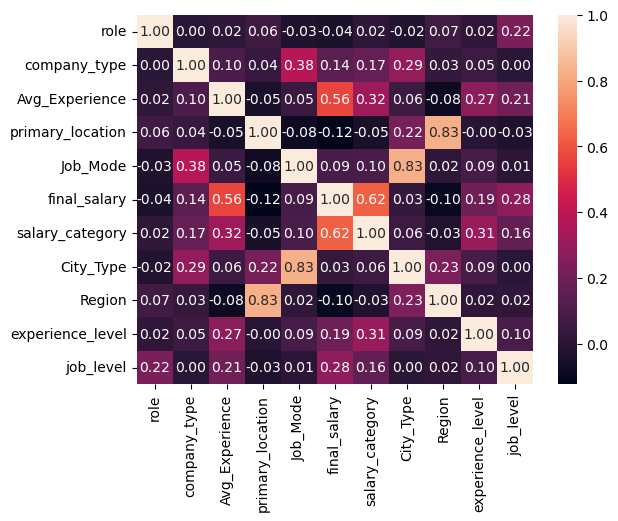

In [29]:
sns.heatmap(df.corr(),annot = True, fmt =".2f")
plt.show()

In [30]:
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = df.drop(columns=['final_salary'])  # Exclude target column
y = df['final_salary']  # Target variable


In [31]:

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42
                                                   
                                                   )

In [32]:
X_train.shape

(1384, 10)

In [33]:
X_test.shape

(346, 10)

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import numpy as np  # Ensure numpy is imported

# Function to train models and evaluate performance
def train_and_evaluate(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n📌 {model_name} Performance:")
    print(f"✅ MAE: {mae:.2f}")
    print(f"✅ RMSE: {rmse:.2f}")
    print(f"✅ R² Score: {r2:.4f}")

# Train and evaluate different models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function="RMSE", verbose=0),
    "Support Vector Regression (SVR)": SVR(kernel="rbf", C=1.0, epsilon=0.1)
}

for model_name, model in models.items():
    train_and_evaluate(model, model_name)


📌 Linear Regression Performance:
✅ MAE: 6.08
✅ RMSE: 8.76
✅ R² Score: 0.6043

📌 Decision Tree Performance:
✅ MAE: 4.54
✅ RMSE: 7.05
✅ R² Score: 0.7438

📌 Random Forest Performance:
✅ MAE: 3.77
✅ RMSE: 5.62
✅ R² Score: 0.8373

📌 Gradient Boosting Performance:
✅ MAE: 4.16
✅ RMSE: 5.69
✅ R² Score: 0.8330

📌 XGBoost Performance:
✅ MAE: 3.74
✅ RMSE: 5.70
✅ R² Score: 0.8328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85
[LightGBM] [Info] Number of data points in the train set: 1384, number of used features: 10
[LightGBM] [Info] Start training from score 21.841908

📌 LightGBM Performance:
✅ MAE: 4.02
✅ RMSE: 5.78
✅ R² Score: 0.8278

📌 CatBoost Performance:
✅ MAE: 4.34
✅ RMSE: 5.93
✅ R² Score: 0.8189

📌 Support Vector Regression (SVR) Performance:
✅ MAE: 6.69
✅ RMSE: 10.03
✅ R² Score: 

# Stacking 

In [42]:
# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)),
    ('lgbm', LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)),
    ('cat', CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, silent=True, random_state=42)),
    ('gbm', GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42))
]

# Define meta-model
meta_model = LinearRegression()

# Create Stacking Regressor
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, n_jobs=-1)

# Train the model
stacking_regressor.fit(X_train, y_train)

# Save the model
joblib.dump(stacking_regressor, "stacking_model.pkl")
print("✅ Model saved successfully!")

# Predictions
y_train_pred_stack = stacking_regressor.predict(X_train)
y_test_pred_stack = stacking_regressor.predict(X_test)

# Define evaluation function
def evaluate_model(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Already squared=False
    print(f"📌 {dataset_name} Performance:")
    print(f"✅ R² Score: {r2:.4f}")
    print(f"✅ MAE: {mae:.4f}")
    print(f"✅ RMSE: {rmse:.4f}\n")

# Evaluate training & testing performance
evaluate_model(y_train, y_train_pred_stack, "Training")
evaluate_model(y_test, y_test_pred_stack, "Testing")

✅ Model saved successfully!
📌 Training Performance:
✅ R² Score: 0.9287
✅ MAE: 2.7158
✅ RMSE: 4.0869

📌 Testing Performance:
✅ R² Score: 0.8481
✅ MAE: 3.7425
✅ RMSE: 5.4304

